In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [3]:
X, y = mnist['data'],mnist['target']

In [4]:
X.shape

(70000, 784)

In [7]:
y.shape

(70000,)

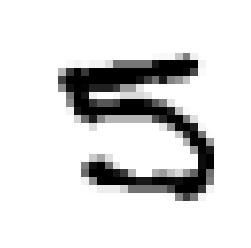

5.0


In [82]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

some_indice = np.random.randint(len(X))
some_digit = X[some_indice]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()
print(y[some_indice])

The MNIST dataset is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images):

In [49]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Let’s also shuffle the training set; this will guarantee that all cross-validation folds will be similar (you don’t want one fold to be missing some digits). Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. Shuffling the dataset ensures that this won’t happen:

In [51]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Training a Binary Classifier

Let’s simplify the problem for now and only try to identify one digit—for example, the number 5. 

In [68]:
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

In [69]:
from sklearn.linear_model import SGDClassifier

In [71]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

C:\Users\jinj3\AppData\Local\Continuum\anaconda3\envs\mlbook\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [83]:
sgd_clf.predict([some_digit])

array([ True])